# Inferring material properties of a cantilevered beam

Recall the beam from last week. Previously, we fixed the material properties and inferred the applied load.  Here we flip the problem, the loads will be fixed and we will infer the material properties.

<img src="BeamDrawing.png" width=300px>

### Formulation:

Again, let $u(x)$ denote the vertical deflection of the beam and let $m(x)$ denote the vertial force acting on the beam at point $x$ (positive for upwards, negative for downwards).  We assume that the displacement can be well approximated using Euler-Bernoulli beam theory and thus satisfies the PDE
$$
\frac{\partial^2}{\partial x^2}\left[ \exp[m(x)] \frac{\partial^2 u}{\partial x^2}\right] = f(x),
$$
where $E(x)=\exp[m(x)]$ is an effective stiffness that depends both on the beam geometry and material properties.  Our goal is to infer $m(x)$ given a few point observations of $u(x)$ and a known load $f(x)$.

The same cantilever boundary conditions are used as before.  These take the form
$$
u(x=0) = 0,\quad \left.\frac{\partial u}{\partial x}\right|_{x=0} = 0
$$
and
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x=L} = 0, \quad  \left.\frac{\partial^3 u}{\partial x^3}\right|_{x=L} = 0.
$$

We assume that $m(x)$ is piecwise constant over $P$ nonoverlapping intervals on $[0,L]$.  More precisely,
$$
m(x) = \sum_{i=1}^P m_i \,I\left(x\in [a_i, a_{i+1})\right),
$$
where $I(\cdot)$ is an indicator function.  

#### Prior
For the prior, we assume each value is an independent normal random variable
$$
m_i \sim N(\mu_i, \sigma_i^2).
$$

#### Likelihood
Let $N_x$ denote the number of finite difference nodes used to discretize the Euler-Bernoulli PDE above.  For this problem, we will have observations of the solution $u(x)$ at $N_y$ of the finite difference nodes.  Let $u\in\mathbb{R}^{N_x}$ (without the $(x)$) denote a vector containing the finite difference solution and let $y\in\mathbb{R}^{N_y}$ denote the observable random variable, which is the solution $u$ at $N_y$ nodes plus some noise $\epsilon$, i.e.
$$
y = Bu + \epsilon,
$$
where $\epsilon \sim N(0, \Sigma_y)$.  The solution vector $u$ is given by
$$
u = [K(m)]^{-1}f,
$$
where $K$ represents the discretization of the Euler-Bernoulli PDE as a function of $m$.  Combining this with the definition of $y$, we have the complete forward model
$$
y = B[K(m)]^{-1} f + \epsilon
$$

The likelihood function then takes the form:
$$
p(y | m) = N\left(\, B [K(m)]^{-1} f,\,\,\Sigma_y \,\right) 
$$

#### Posterior
Evaluating the posterior, which is simply written as 
$$
p(m|y) \propto p(y|m)p(m),
$$
involves several steps.  The computational graph below highlights the steps necessary to evaluate the posterior.  This graph is also similar to the one we will construct with MUQ below.

<img src="PosteriorGraphStart.png" width=500px>

## Imports

In [1]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

import pandas as pd

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import h5py

# Import forward model class
from BeamModel import EulerBernoulli

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC


## Load the data and finite difference model

In [2]:
f = h5py.File('ProblemDefinition.h5','r')

nodes = np.array( f['/ForwardModel/NodeLocations'] )
B = np.array( f['/Observations/ObservationMatrix'] )
obsData = np.array( f['/Observations/ObservationData'] )

length = f['/ForwardModel'].attrs['BeamLength']
radius = f['/ForwardModel'].attrs['BeamRadius']

loads = np.array( f['/ForwardModel/Loads'])

numObs = obsData.shape[0]
numPts = nodes.shape[1]
dim = 1

### Define the material property intervals

In [3]:
numIntervals = 3
endPts = np.linspace(0,1,numIntervals+1)
intervals = [(endPts[i],endPts[i+1]) for i in range(numIntervals)]

## Define the prior

In [4]:
logPriorMu = 10*np.ones(numIntervals)
logPriorCov = 4.0*np.eye(numIntervals)

logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

## Define the forward model

In [5]:
class LumpedToFull(mm.PyModPiece):
    
    def __init__(self, intervals, nodes):
        """ 
        INPUTS:
          - Intervals is a list of tuples containing the intervals that define the 
            parameter field. 
          - pts is a vector containing the locations of the finite difference nodes
        """
        P = len(intervals)
        num_nodes = nodes.shape[1]
        mm.PyModPiece.__init__(self, [P], # One input containing lumped params
                                     [num_nodes]) # One output containing the full E field
        
        # build a vector of indices mapping an index in the full vector to a continuous parameter
        self.node_to_interval = np.zeros(num_nodes, dtype=np.uint)
        
        for i in range(P):
            self.node_to_interval[ (nodes[0,:]>=intervals[i][0]) & (nodes[0,:] <= intervals[i][1]) ] = i
            
            
    def EvaluateImpl(self, inputs):
        """
        - inputs[0] will contain a vector with the values m_i in each interval
        - Needs to compute a vector "mField" containing m at each of the finite difference nodes
        - Should set the output using something like "self.outputs = [ mField ]"
        """
        self.outputs = [ inputs[0][self.node_to_interval] ]

### Test Evaluation

In [6]:
mField      = LumpedToFull(intervals, nodes )
m3 = np.array([1.0, 2.0, 3.0])
# mField.Evaluate([m3])[0]


In [7]:
expmVals    = mm.ExpOperator(numIntervals) # component-wise exponentiation
loadPiece   = mm.ConstantVector(loads) 
obsOperator = mm.DenseLinearOperator(B) # takes in vector v, return Bv

In [8]:
# EulerBernoullie is a child of ModPiece with two inputs:
# 1. A vector of loads at each finite difference node
# 2. A vector containing the material property (exp(m(x))) at each finite difference node
beamModel = EulerBernoulli(numPts, length, radius)

In [10]:
# EulerBernoulli?
beamModel.inputSizes, beamModel.outputSizes

(array([31, 31], dtype=int32), array([31], dtype=int32))

## Likelihood function

$$
p(y | m) = N(Bu, \Sigma_y)
$$

$$
p(Bu) = N(y, \Sigma_y)
$$

In [11]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

## Posterior

In [12]:
posteriorPiece = mm.DensityProduct(2)
mPiece = mm.IdentityOperator(numIntervals)

In [13]:
graph = mm.WorkGraph()

# Named according to the output of each modpiece
mi = "m_i"
exp_mi = "exp(m_i)"
exp_mx = "exp(m(x))"
f_node = "f"
B_node = "B"
u_node = "u"
pr = "Prior"
ps = "Posterior"
ll = "Likelihood"

# Forward model nodes and edges
graph.AddNode(mPiece, mi)
graph.AddNode(expmVals, exp_mi)
graph.AddNode(mField, exp_mx)
graph.AddNode(loadPiece, f_node)
graph.AddNode(obsOperator, B_node)
graph.AddNode(beamModel, u_node)


graph.AddEdge(mi, 0, exp_mi, 0)
graph.AddEdge(exp_mi, 0, exp_mx, 0)
graph.AddEdge(exp_mx, 0, u_node, 1)
graph.AddEdge(f_node, 0, u_node, 0)
graph.AddEdge(u_node, 0, B_node, 0)

# Other nodes and edges
graph.AddNode(likelihood, ll)
graph.AddNode(logPrior, pr)
graph.AddNode(posteriorPiece, ps)

graph.AddEdge(B_node, 0, ll, 0) # observations made define the likelihood
graph.AddEdge(mi, 0, pr, 0) # prior density requires samples
graph.AddEdge(pr, 0, ps, 0) # posterior requires prior
graph.AddEdge(ll, 0, ps, 1) # posterior requires likelihood

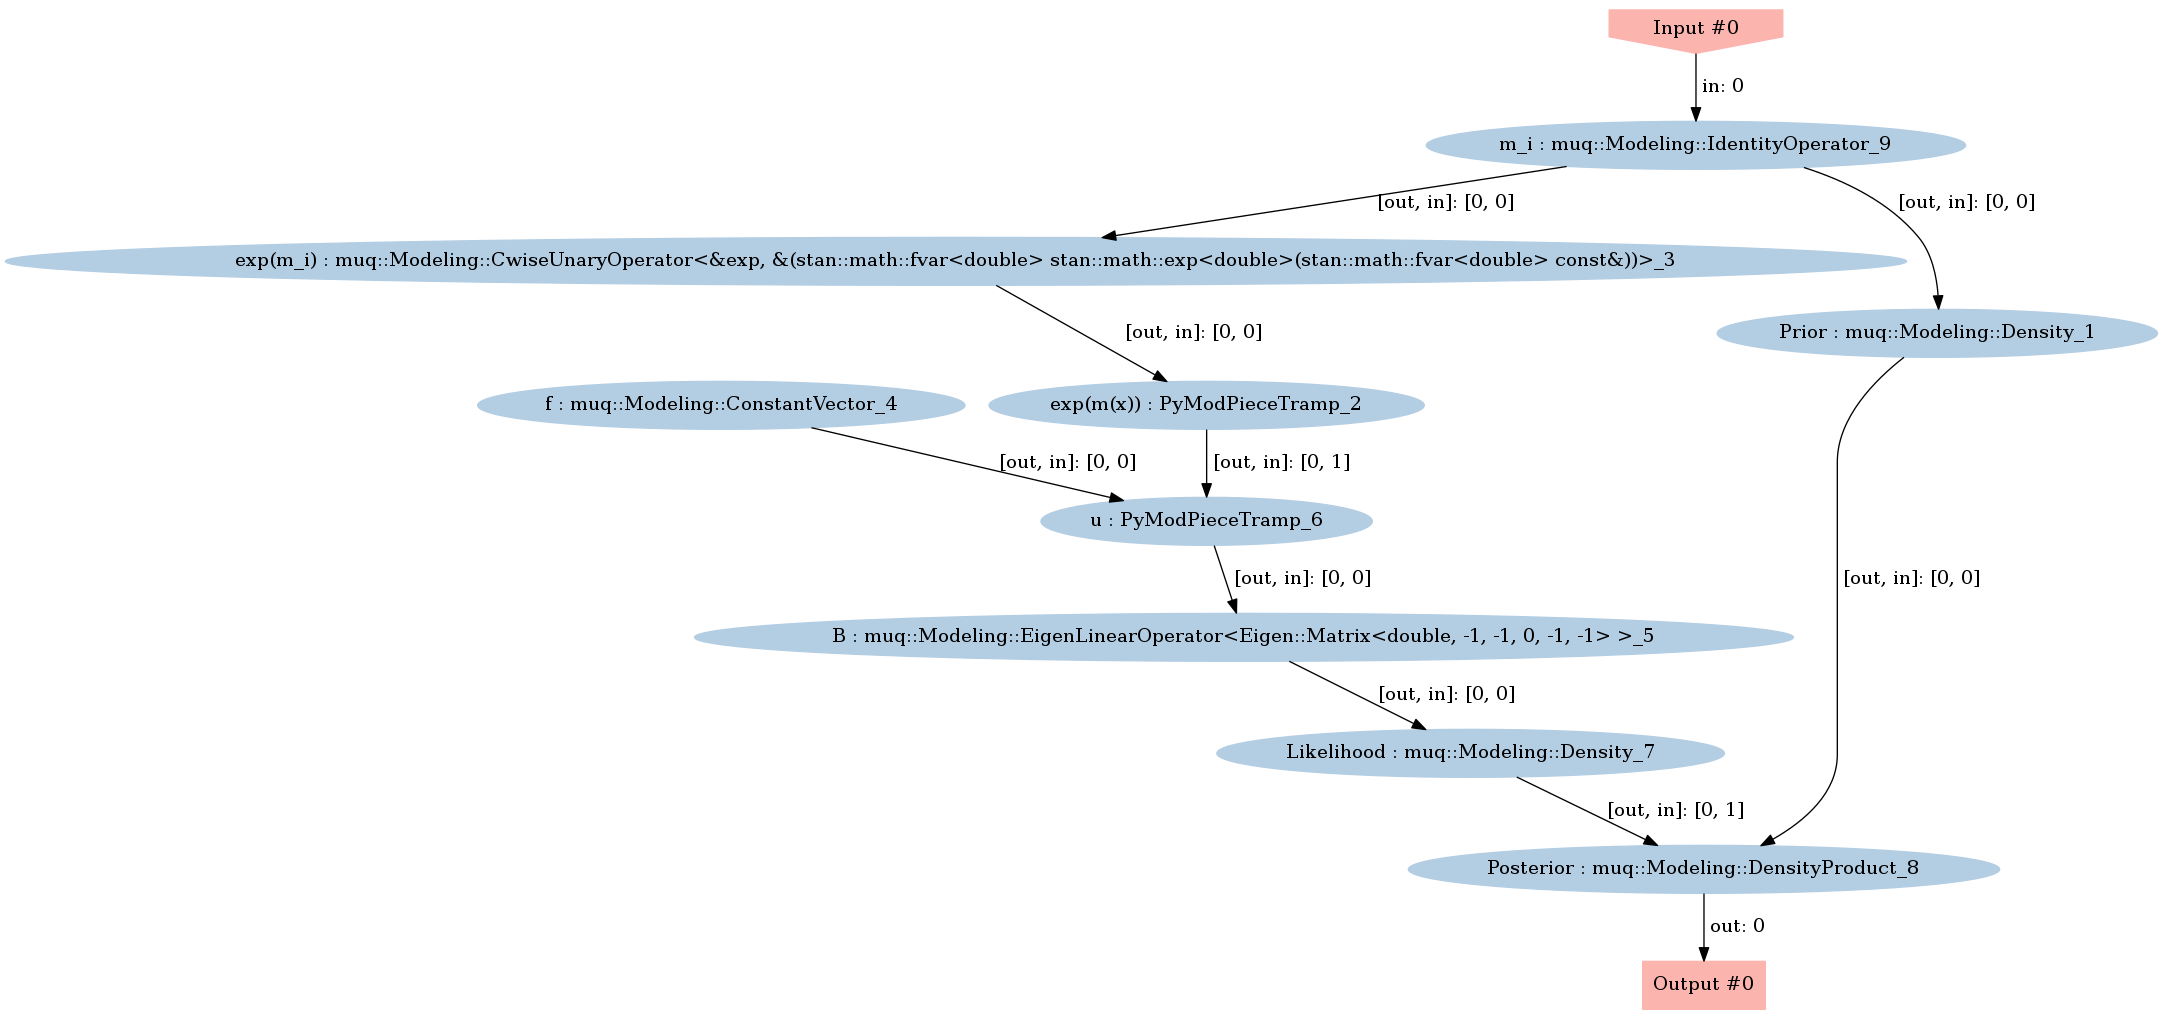

In [14]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [15]:
problem = ms.SamplingProblem( graph.CreateModPiece(ps) )

In [16]:
# Proposal-level Parameters
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-2
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

# Kernel-level Parameters
kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions
# If you had other proposal/options, can simply modify the RHS of this

# Chain-level Parameters
options = dict()
options['NumSamples'] = 50000
options['ThinIncrement'] = 1
options['BurnIn'] = 10000
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions
# If you had other kernels, can simply modify the RHS of this

mcmc = ms.SingleChainMCMC(options,problem)

In [17]:
startPt = 10.0*np.ones(numIntervals)
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 20%
  20% Complete
    Block 0:
      Acceptance Rate = 25%
  30% Complete
    Block 0:
      Acceptance Rate = 26%
  40% Complete
    Block 0:
      Acceptance Rate = 26%
  50% Complete
    Block 0:
      Acceptance Rate = 26%
  60% Complete
    Block 0:
      Acceptance Rate = 26%
  70% Complete
    Block 0:
      Acceptance Rate = 26%
  80% Complete
    Block 0:
      Acceptance Rate = 27%
  90% Complete
    Block 0:
      Acceptance Rate = 27%
  100% Complete
    Block 0:
      Acceptance Rate = 28%
Completed in 5.41617 seconds.


In [18]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

Effective Sample Size = 
 [  65.31224416   63.8739647   170.35074709]

Sample mean = 
 [ 9.25287959  9.2579939   9.22784614]

Sample Covariance = 
 [[  5.81453471e-03   5.29102490e-03   4.82760380e-05]
 [  5.29102490e-03   5.28598699e-03   1.79062740e-04]
 [  4.82760380e-05   1.79062740e-04   2.33819645e-03]]

Estimated MC error in mean = 
 [ 0.0094354   0.00909706  0.00370483]


In [19]:
sampMat = samps.AsMatrix()

## Plot the posterior samples

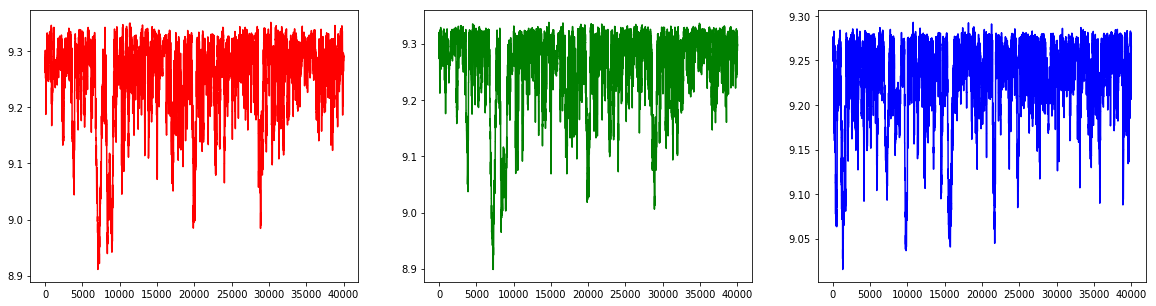

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
colors = ['r', 'g', 'b']
for i in range(numIntervals):
    axs[i].plot(sampMat[i,:].T, c=colors[i])
plt.show()

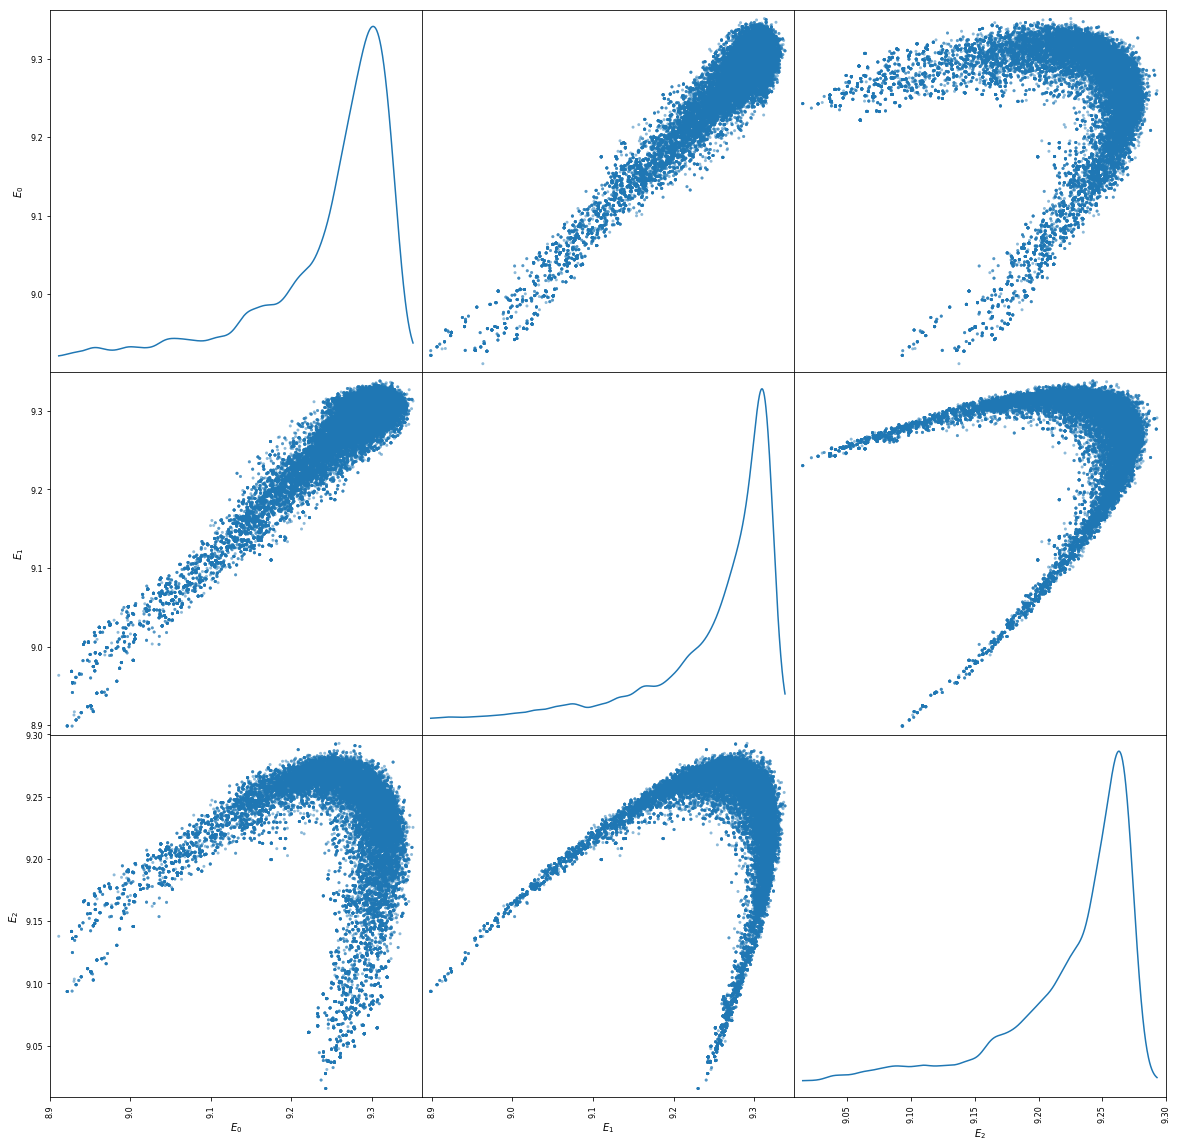

In [21]:
df = pd.DataFrame(sampMat.T, columns=['$E_%d$'%i for i in range(numIntervals) ])
pd.plotting.scatter_matrix(df, diagonal='kde', figsize=(20,20), alpha=0.5)
plt.show()

## Plot samples of the posterior predictive

In [22]:
predSamps = np.zeros((numPts, sampMat.shape[1]))

predModel = graph.CreateModPiece("u")

for i in range(sampMat.shape[1]):
    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]
    

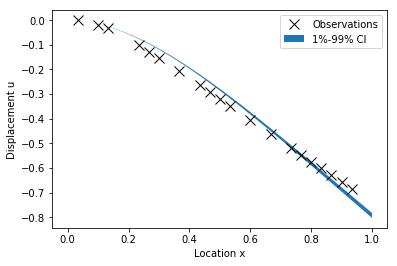

In [23]:
# Plot quantiles
plt.fill_between(nodes[0,:], 
                 np.percentile(predSamps,1,axis=1),
                 np.percentile(predSamps,99,axis=1),
                 edgecolor='none', label='1%-99% CI')

# Plot the observations
obsInds = np.where(B>0)[1]
plt.plot(nodes[0,obsInds], obsData, 'xk', markerSize=10, label='Observations')

plt.legend()
plt.xlabel('Location x')
plt.ylabel('Displacement u')
plt.show()

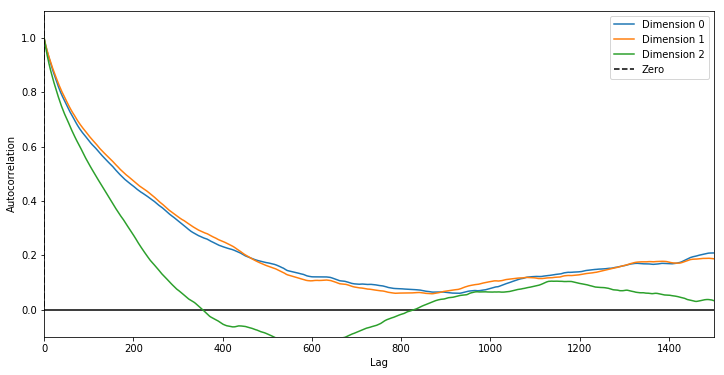

In [24]:
fig = plt.figure(figsize=(12,6))

for i in range(numIntervals):
    shiftedSamp = sampMat[i,:]-np.mean(sampMat[i,:])
    corr = np.correlate(shiftedSamp, shiftedSamp, mode='full')
    plt.plot(corr[int(corr.size/2):]/np.max(corr), label='Dimension %d'%i)
    
maxLagPlot = 1500
plt.plot([-maxLagPlot,0.0],[4.0*maxLagPlot,0.0],'--k', label='Zero')
plt.xlabel('Lag')
plt.hlines(0,0,maxLagPlot)
plt.ylabel('Autocorrelation')
plt.xlim([0,maxLagPlot])
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()